In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ncr/sample_submission.csv
/kaggle/input/ncr/train.csv
/kaggle/input/ncr/test.csv


In [2]:
x_train = pd.read_csv('/kaggle/input/ncr/train.csv')
x_test = pd.read_csv('/kaggle/input/ncr/test.csv')
submit = pd.read_csv('/kaggle/input/ncr/sample_submission.csv')

In [3]:
y_train = x_train.label
x_train = x_train.drop('label',axis=1)

In [4]:
lst = x_train.columns.tolist()

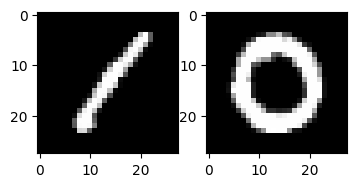

In [5]:
import matplotlib.pyplot as plt

train_0 = np.array(x_train.loc[0,lst])
train_1 = np.array(x_train.loc[1,lst])
train_image_0 = np.reshape(train_0,(28,28,1))
train_image_1 = np.reshape(train_1,(28,28,1))
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 8))
ax[0].imshow(train_image_0, cmap='gray')
ax[1].imshow(train_image_1, cmap='gray')

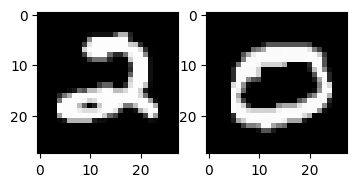

In [6]:
test_0 = np.array(x_test.loc[0,lst])
test_1 = np.array(x_test.loc[1,lst])
test_image_0 = np.reshape(test_0,(28,28,1))
test_image_1 = np.reshape(test_1,(28,28,1))
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 8))
ax[0].imshow(test_image_0, cmap='gray')
ax[1].imshow(test_image_1, cmap='gray')

In [7]:
def data_prep(raw):
    num_images = raw.shape[0]
    x_as_array = raw.values[:,:]
    x_shaped_array = x_as_array.reshape(num_images, 28, 28, 1)
    out_x = x_shaped_array / 255
    return out_x

In [8]:
x = data_prep(x_train)
y = pd.get_dummies(y_train)

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
import keras_tuner as kt

def build_model(hp):
    model = Sequential([
         Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)),
         MaxPooling2D(2, 2),
         Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
         MaxPooling2D(2, 2),
         Dropout(hp.Choice('drop', values=[0.5])),
         Flatten(),
         Dense(32, activation='relu'),
         Dense(10, activation=hp.Choice('output_activation', values=['sigmoid']))
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001])), loss = hp.Choice('losses_set', values=['categorical_crossentropy']), metrics=["accuracy"])
    return model    

2024-02-12 11:52:42.530778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 11:52:42.530925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 11:52:42.731246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 1,
    directory ='test'
)

In [11]:
tuner.search(x, y, batch_size=128, epochs=20, validation_split = 0.3)

Trial 1 Complete [00h 08m 08s]
val_accuracy: 0.990318238735199

Best val_accuracy So Far: 0.990318238735199
Total elapsed time: 00h 08m 08s


In [12]:
models = tuner.get_best_models(1)

In [13]:
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0

In [14]:
models[0].fit(x, y)

1313/1313 [==============================] - 38s 28ms/step - loss: 0.0452 - accuracy: 0.9856


In [15]:
xt = data_prep(x_test)

In [16]:
y_pred = models[0].predict(xt)

875/875 [==============================] - 8s 10ms/step


In [17]:
df = pd.DataFrame(data=y_pred)

In [18]:
dx = df.idxmax(axis=1)

In [19]:
submit['Label'] = np.array(dx)

In [20]:
submit

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [21]:
submit.to_csv('submission.csv',index=False)